In [22]:
import pandas as pd 
pd.read_csv('bank-full.csv', sep=";") 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [25]:
print(data.isnull().sum())


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [30]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

categorical_columns = data.select_dtypes(include=["object"]).columns

label_encoder = LabelEncoder()

data["y"] = label_encoder.fit_transform(data["y"])  

categorical_columns = categorical_columns[categorical_columns != "y"]

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

scaler = StandardScaler()
numerical_columns = data_encoded.select_dtypes(include=["int64", "float64"]).columns.drop("y")
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

print("\nPreprocessed Dataset Info:")
print(data_encoded.info())




Preprocessed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45211 non-null  float64
 1   balance              45211 non-null  float64
 2   day                  45211 non-null  float64
 3   duration             45211 non-null  float64
 4   campaign             45211 non-null  float64
 5   pdays                45211 non-null  float64
 6   previous             45211 non-null  float64
 7   y                    45211 non-null  int64  
 8   job_blue-collar      45211 non-null  bool   
 9   job_entrepreneur     45211 non-null  bool   
 10  job_housemaid        45211 non-null  bool   
 11  job_management       45211 non-null  bool   
 12  job_retired          45211 non-null  bool   
 13  job_self-employed    45211 non-null  bool   
 14  job_services         45211 non-null  bool   
 15  job_stud

In [31]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X = data_encoded.drop(columns=["y"])
y = data_encoded["y"]

selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

top_features = pd.DataFrame({"Feature": selected_features, "Score": feature_scores}).sort_values(by="Score", ascending=False)
print("\nTop Selected Features:")
print(top_features)


Top Selected Features:
            Feature     Score
3          duration  0.074293
4             pdays  0.029775
8  poutcome_success  0.027511
1           balance  0.020534
9  poutcome_unknown  0.018501
6       housing_yes  0.017192
7   contact_unknown  0.015441
5          previous  0.012772
0               age  0.012550
2               day  0.008779


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

X_selected = X[selected_features]

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1-Score": make_scorer(f1_score),
}

cv_results = {model_name: {} for model_name in models}
for model_name, model in models.items():
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(model, X_selected, y, cv=5, scoring=scorer)
        cv_results[model_name][metric_name] = np.mean(scores)

print("\nModel Evaluation Results:")
for model_name, metrics in cv_results.items():
    print(f"Results for {model_name}:")
    for metric_name, score in metrics.items():
        print(f"  {metric_name}: {score:.4f}")
    print()



Model Evaluation Results:
Results for Logistic Regression:
  Accuracy: 0.8890
  Precision: 0.6343
  Recall: 0.2777
  F1-Score: 0.3555

Results for Decision Tree:
  Accuracy: 0.7840
  Precision: 0.2445
  Recall: 0.3569
  F1-Score: 0.2674

Results for Random Forest:
  Accuracy: 0.8260
  Precision: 0.4127
  Recall: 0.2944
  F1-Score: 0.2485



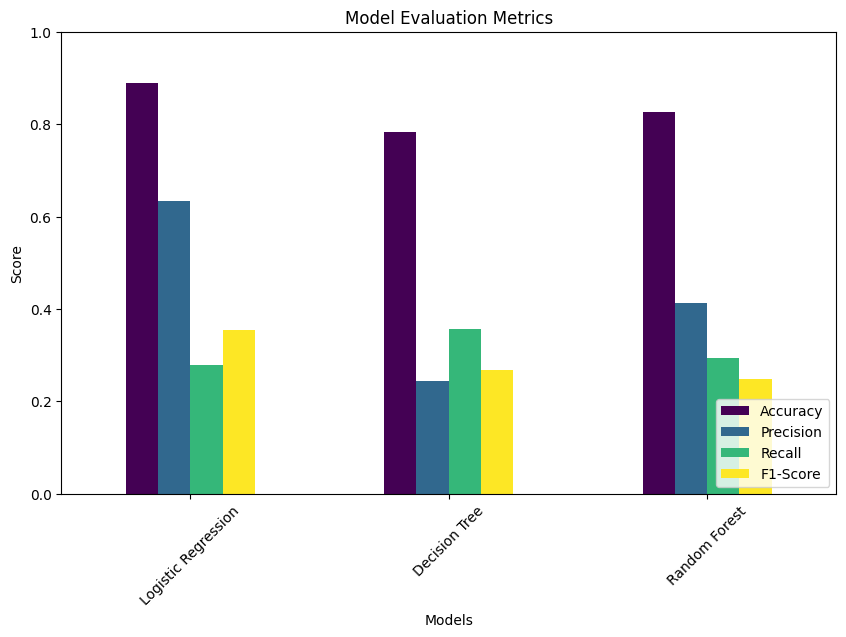

In [39]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame(cv_results).T
results_df = results_df[["Accuracy", "Precision", "Recall", "F1-Score"]]

# Plot results
results_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.show()